In [1]:
from __future__ import print_function    
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import pylab as py
import scipy.sparse as sp                 
from scipy.sparse.linalg import spsolve
import scipy.sparse as sp

   

In [2]:
# Conditions de Dirichlet sur les bords du maillage
uL = 0
uR = 0
uT = 0
uB = 0

#Conditions de Dirichlet dans l'espace
eo = 8.85e-12
upos = 1/eo
uneg = -1/eo

# Maillage de l'espace
I = 65
J = 65                       
x = np.linspace(0,1,I)     
y = np.linspace(0,1,J)        

dx = x[1] - x[0]                #pas selon x
dy = y[1] - y[0]                #pas selon y

X,Y = np.meshgrid(x,y)       #création de la matrice de maillage   

# Réindexation 2D à 1D
Xu = X.ravel()                  # Créer l'array des abscisses 1D
Yu = Y.ravel()

#Création du condensateur
 
xlimite = [0.25, 0.75]        # on limite la zone de x 
k = np.floor(0.4/dy)          #ce sont les lignes qui correspondent aux lignes dans le maillage ou on a y  = 0.4 et y = 0.6
k1 = np.floor(0.6/dy)
yupos = k*dy                 # j'ai ajusté avec la partie entière pour qu'on ai approximativement 0.4 (c'est dû au maillage que je réalise avec la fonciton linspace)
yuneg = k1*dy                 #pareil pour que ça donne 0.6 approximativement mais pour que ça tombe juste sur le maillage

print(k,k1)


25.0 38.0


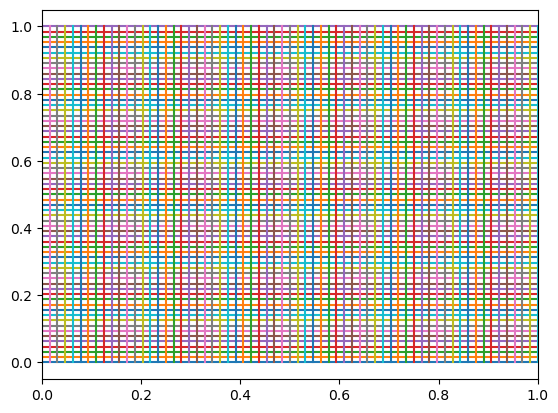

In [3]:
#Création du maillage sur x et y 
plt.plot(X)
plt.plot(X,Y)
plt.xlim([0,1])
plt.show()

In [9]:
# Indices des bords pour construire la boite avec les conditions de Dirichlet

ind_bord_gauche = np.squeeze(np.where(Xu==x[0]))          # renvoie l'indice des bords à gauche de la boite 
ind_bord_droit = np.squeeze(np.where(Xu==x[I-1]))       
ind_bord_bas = np.squeeze(np.where(Yu==y[0]))         
ind_bord_haut = np.squeeze(np.where(Yu==y[J-1]))  

# Indices des lignes de charges positives et négatives
#ligne positive
list_charge_pos = np.squeeze(np.where((Xu>xlimite[0]) & (Xu<xlimite[1]) & (Yu==yupos)))  # renvoie l'indice des lignes ou il y a les charges positives dans la liste déroulée de la matrice
list_charge_pos_reel = np.where((X>xlimite[0]) & (X<xlimite[1]) & (Y==yupos))    # renvoie la position des lignes ou il y a les charges positives sur la vrai matrice de maillage
#ligne négative
list_charge_neg = np.squeeze(np.where((Xu>xlimite[0]) & (Xu<xlimite[1]) & (Yu==yuneg)))  # renvoie l'indice des lignes ou il y a les charges négatives
list_charge_neg_reel = np.where((X>xlimite[0]) & (X<xlimite[1]) & (Y==yuneg))    

# Indices du maillages
ind_bords_unravel = np.squeeze(np.where((Xu==x[0]) | (Xu==x[I-1]) | (Yu==y[0]) | (Yu==y[J-1])))  # tous les bords en indice listé 
ind_bords = np.where((X==x[0]) | (X==x[I-1]) | (Y==y[0]) | (Y==y[J-1]))    # tous les bords/leur position réel sur le maillage

print(ind_bord_bas, ind_bord_gauche, list_charge_neg_reel)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] [   0   65  130  195  260  325  390  455  520  585  650  715  780  845
  910  975 1040 1105 1170 1235 1300 1365 1430 1495 1560 1625 1690 1755
 1820 1885 1950 2015 2080 2145 2210 2275 2340 2405 2470 2535 2600 2665
 2730 2795 2860 2925 2990 3055 3120 3185 3250 3315 3380 3445 3510 3575
 3640 3705 3770 3835 3900 3965 4030 4095 4160] (array([38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38],
      dtype=int64), array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
      dtype=int64))


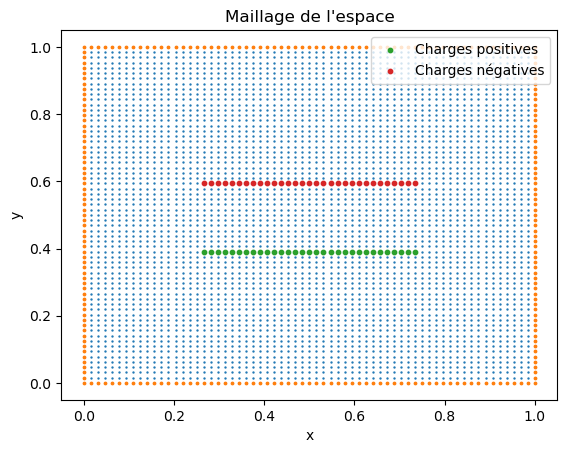

In [10]:
plt.scatter(X,Y,2,marker = '.') # création de l'espace maillé
plt.scatter(X[ind_bords],Y[ind_bords],3) # création des bords
plt.scatter(X[list_charge_pos_reel],Y[list_charge_pos_reel],10, label = 'Charges positives')
plt.scatter(X[list_charge_neg_reel],Y[list_charge_neg_reel],10,label = 'Charges négatives')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Maillage de l'espace")
plt.legend()

In [11]:
# Construction du vecteur source du système de Poisson

#Création de la matrice source 

b = np.zeros(I*J) 
b[ind_bord_gauche] = uL # on rajoute les conditions sur les bords du maillage
b[ind_bord_droit] = uR
b[ind_bord_haut] = uT
b[ind_bord_bas] = uB

b[list_charge_pos] = upos # on rajoute les charges positives et négatives sur les lignes dans le vecteur b
b[list_charge_neg] = uneg

print(b)

[0. 0. 0. ... 0. 0. 0.]


In [71]:
# Implémentation du pivot de Gauss pour résoudre un systeme du type Ax = B

def produit(A, B):
    return [[sum(L[k] * B[k][j] for k in range(len(L))) for j in range(len(B[0]))] for L in A]

def echange_lignes(M, i, j):
   M[i], M[j] = M[j], M[i]
   return M
   
def transvection_ligne(M, i, j, l):
    M[i] = [M[i][k] + l * M[j][k] for k in range(len(M[i]))]
    return M
   
def dilatation_ligne(M, i, l):
    M[i] = [coeff * l for coeff in M[i]]
    return M
   
def recherche_pivot_lignes(M, i):
    m = abs(M[i][i])
    j = i
    for k in range(i + 1, len(M)):
        if abs(M[i][j]) > m:
            j = k
    return j
   
def pivot_lignes(M):
   for i in range(len(M)):
        j = recherche_pivot_lignes(M, i)
        if j != i:
            echange_lignes(M, i, j)
        if M[i][i] != 0:
            for j in range(i + 1, len(M)):
                transvection_ligne(M, j, i, -M[j][i] / M[i][i])
   return M
   
def concatenation_vecteur(A, B):
    return [A[i] + [B[i]] for i in range(len(A))]

def pivot_lignes_rebours(M):
    for i in reversed(range(len(M))):
        dilatation_ligne(M, i, 1 / M[i][i])
        for j in range(i):
            transvection_ligne(M, j, i, -M[j][i])
    return M

def extract_vecteur(M):
    return [L[-1] for L in M]

def resolution(A, B):
    M = concatenation_vecteur(A, B)
    pivot_lignes(M)
    pivot_lignes_rebours(M)
    return extract_vecteur(M)

In [72]:
A = [[1, -1, 2], [3, 2, 1], [2, -3, -2]]
B = [5, 10, -10]
resolution(A,B)

[1.0, 2.0, 3.0]

In [102]:
# Méthode utilisant la méthode des différences finies
#avec np.linalg.solve pour résoudre le système 
def poisson_matrice_linalg(n, dx):
    h = dx
    A = np.zeros((n*n, n*n), dtype=float)
    for i in range(n*n):
        A[i, i] = -4 #ne marche que si le pas est le même dans le sens des x et y 
    for i in range(n):
        for j in range(n-1):
            A[n*i+j, n*i+j+1] = 1
            A[n*i+j+1, n*i+j] = 1
    for i in range(n-1):
        for j in range(n):
            A[n*(i+1)+j, n*i+j] = 1
            A[n*i+j, n*(i+1)+j] = 1
    v = b
    return np.linalg.solve(A, v).reshape((n, n))

#par la méthode du pivot de gauss
def poisson_matrice_gauss(n, dx):
    h = dx
    A = np.zeros((n*n, n*n), dtype=float)
    for i in range(n*n):
        A[i, i] = -4
    for i in range(n):
        for j in range(n-1):
            A[n*i+j, n*i+j+1] = 1
            A[n*i+j+1, n*i+j] = 1
    for i in range(n-1):
        for j in range(n):
            A[n*(i+1)+j, n*i+j] = 1
            A[n*i+j, n*(i+1)+j] = 1
    v = b
    return resolution(A, v).reshape((n, n))
       

# Calcul des dérivées partielles de l'équation de Poisson pour la méthode Sparse dans un premier temps on travaille sur une seule dimension et ensuite on l'étend en 2D au maillage 
# Ici comme on manipule des matrices pleines de 0, on utilise la méthode sparse qui consiste à remplir les matrices avec seulement les endroits ou l'élement est non nul attention
# si il y a pas beaucoup de zero cette méthode est très longue car on remplit un par un la matrice mais dans notre cas on manipule des matrices creuses donc on peut utiliser cette 
# méthode 

def Derive1D(Nx):
    
    # Première dérivée
    D_1d = sp.diags([-1, 1], [-1, 1], shape = (Nx,Nx)) # on doit diviser par le pas au carré mais je le ferai à la fin 
    D_1d = sp.lil_matrix(D_1d)                  # Ici on crée la matrice de diag nul, la diag supérieur a celle centrale qui vaut que des 1 et celle d'en dessous qui vaut que des -1 
    D_1d[0,[0,1,2]] = [-3, 4, -1]               # on créer la première dérivée en accord avec la formule de Taylor
    D_1d[Nx-1,[Nx-3, Nx-2, Nx-1]] = [1, -4, 3]  
    
    # Seconde dérivée
    D2_1d =  sp.diags([1, -2, 1], [-1,0,1], shape = (Nx, Nx)) # on doit diviser par le pas au carré mais je le ferai à la fin
    D2_1d = sp.lil_matrix(D2_1d)                  
    D2_1d[0,[0,1,2,3]] = [2, -5, 4, -1]                    
    D2_1d[Nx-1,[Nx-4, Nx-3, Nx-2, Nx-1]] = [-1, 4, -5, 2]  
    
    return D_1d, D2_1d


def Derive2D(Nx,Ny):
    
    Dx_1d, D2x_1d = Derive1D(Nx)
    Dy_1d, D2y_1d = Derive1D(Ny)
    
    # matrice identité sparse
    Ix = sp.eye(Nx)
    Iy = sp.eye(Ny)

    # utilisation du produit de kronecker pour la fabriquation de la matrice 2D
    # Première dérivée partielle
    Dx_2d = sp.kron(Iy,Dx_1d)
    Dy_2d = sp.kron(Dy_1d,Ix)
    
    # deuxième dérivée partielle
    D2x_2d = sp.kron(Iy,D2x_1d)
    D2y_2d = sp.kron(D2y_1d,Ix)
    
    return Dx_2d.tocsr(), Dy_2d.tocsr(), D2x_2d.tocsr(), D2y_2d.tocsr()

def itere(u, x, f, n, h, omega):
uu = np.zeros_like(u)
for i in range(1, n+1):
for j in range(1, n+1):
uu[i, j] = (1 − omega) * u[i, j] + omega / 4 * (uu[i, j−1] + uu[i−1, j] + u[i+1, j] + u[i,
                                                                                        
                                                                                         def poisson3(f, n, epsilon, kmax = 500):
h = 1/(n+1)
omega = 2 / (1 + np.sin(np.pi * h))
x = np.linspace(0, 1, n+2)
u = np.zeros((n+2, n+2), dtype=float)
for k in range(kmax):
uu = itere(u, x, f, n, h, omega)
if norm(uu − u, np.inf) / norm(uu, np.inf) < epsilon:
return uu
u = uu
return None


In [97]:
# Résolution de l'équation avec la méthode du pivot de Gauss

start2 = time.time()
u2 = poisson_matrice_gauss(I,dx)
end2 = time.time()
temps_gauss = end2-start2
plt.figure(3)
plt.contourf(x,y,u1,41,cmap ='cosmos')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec la méthode du pivot de Gauss")

print('Le temps pour la méthode linalg.solve est',temps_gauss)
#Ici on se rends compte que le temps de calcul est beaucoup trop long... J'aurai essayé au moins mais la méthode du pivot de Gauss est ici 
#impossible à appliquer

KeyboardInterrupt: 

Le temps pour la méthode sparse est 0.029147863388061523
Le temps pour la méthode linalg.solve est 0.34061264991760254


Text(0.5, 1.0, "Résolution de l'équation de Poisson avec la méthode Sparse de scipy")

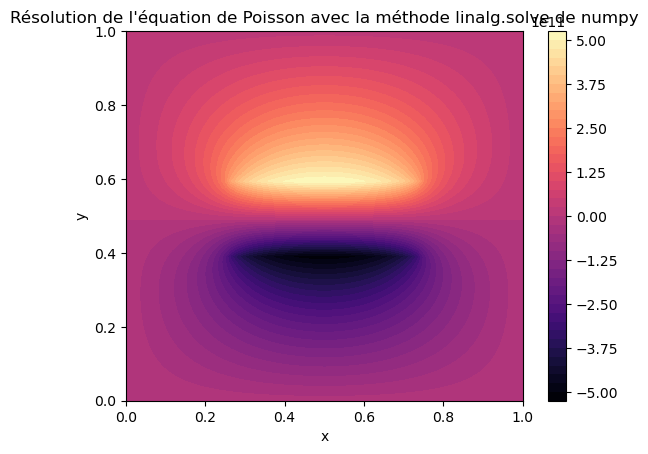

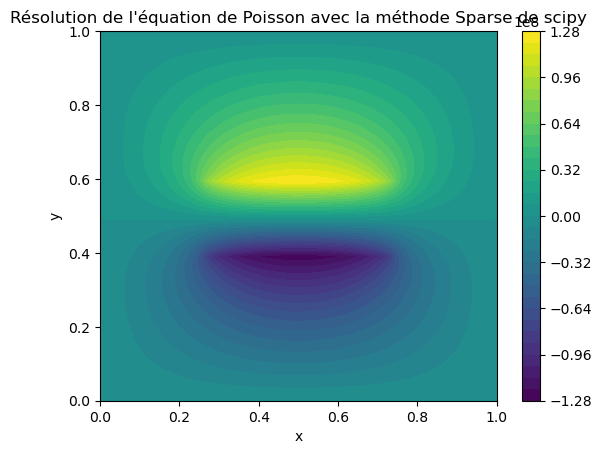

In [103]:
# Résolution de l'équation de Poisson avec la méthode sparse

start1 = time.time()
Dx_2d, Dy_2d, D2x_2d, D2y_2d = Derive2D(I,J)   
I_sp = sp.eye(I*J).tocsr()
L_sys = D2x_2d/dx**2 + D2y_2d/dy**2     # le système sans les conditions au limite
L_sys[ind_bords_unravel,:] = I_sp[ind_bords_unravel,:] #on rajoute les conditions au limite
u = spsolve(L_sys,b).reshape(I,J)
end1 = time.time()
temps_sparse = end1-start1

# Résolution de l'équation avec linalg.solve du module numpy 

start = time.time()
u1 = poisson_matrice_linalg(I,dx)
end = time.time()
temps_linalg = end-start
plt.figure(2)
plt.contourf(x,y,u1,41,cmap ='magma')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec la méthode linalg.solve de numpy")


# Résolution de l'équation avec la méthode de sur-relaxation





# Affichage du résultat
print('Le temps pour la méthode sparse est',temps_sparse)
print('Le temps pour la méthode linalg.solve est',temps_linalg)

plt.figure(1)
plt.contourf(x,y,u,41)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec la méthode Sparse de scipy")



#pas les mêmes valeurs et lisser
#méthode de sur relaxation 
